In [2]:
!nvidia-smi

Wed Jul 22 19:42:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   40C    P8     8W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   38C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
!pip install watermark

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from load_data import *
#modulos para red
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization, UpSampling2D, Flatten, Conv2D, Conv2DTranspose, LeakyReLU,PReLU, add, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

#manipulación de datos
import numpy as np
import pandas as pd

#manipulación de imagenes
from skimage import io, segmentation as seg
from skimage.transform import resize
from PIL import Image

#visualización de imagenes
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import scipy

In [5]:
%reload_ext watermark
%watermark -a "Christian Dayan Arcos Gordillo" --iversion

scipy      1.1.0
seaborn    0.9.0
pandas     0.25.3
matplotlib 3.1.1
PIL.Image  7.0.0
tensorflow 2.1.0
numpy      1.17.4
Christian Dayan Arcos Gordillo


In [ ]:
dataset_path = "/content/drive/My Drive/Formated-20200425T014201Z-005.zip"
zip_object = zipfile.ZipFile(file=dataset_path,mode='r')
zip_object.extractall('./dataset/')
zip_object.close()

In [ ]:
dataset_path = "./PSF_samuel.zip"
zip_object = zipfile.ZipFile(file=dataset_path,mode='r')
zip_object.extractall('./psf/')
zip_object.close()

In [6]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy.io import loadmat


def Input_image(image):
    images = loadmat(image).get('rad')
    images = images.astype('float32')/np.max(images)
    return images


def Oput_image(image):
    images = loadmat(image).get('rad')
    images = images.astype('float32')/np.max(images)
    return images


def load_sambles(data):
    data = data[['inimg']]
    inimg_name = list(data.iloc[:, 0])
    samples = []
    for samp in inimg_name:
        samples.append(samp)
    return samples

def conv_array(samples, lenData, PATH, IMG_WIDTH, IMG_HEIGHT, L_imput, L_bands, shuffle=True):

    X = np.empty((lenData, IMG_WIDTH, IMG_HEIGHT, L_imput )) 
    y = np.empty((lenData, IMG_WIDTH, IMG_HEIGHT, L_bands))
    
    for i, file_name in enumerate(samples):
        # Store sample
        X[i,] = Input_image(PATH + file_name)
        # Store class
        y[i,] = Oput_image(PATH  + file_name)
    
    return X,y

def Build_data_set(IMG_WIDTH=500, IMG_HEIGHT=500, L_bands=31, L_imput=12, BATCH_SIZE=4, PATH=None):
    # Random split
    #data_dir_list = os.listdir(PATH)
    data_dir_list = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
    N = len(data_dir_list)
    train_df = pd.DataFrame(columns=['inimg'])
    test_df = pd.DataFrame(columns=['inimg'])
    randurls = np.copy(data_dir_list)
    train_n = round(N * 0.80)
    np.random.shuffle(randurls)
    tr_urls = randurls[:train_n]
    ts_urls = randurls[train_n:N]
    for i in tr_urls:
        train_df = train_df.append({'inimg': i}, ignore_index=True)
    for i in ts_urls:
        test_df = test_df.append({'inimg': i}, ignore_index=True)
        
    partition_Train = load_sambles(train_df)
    partition_Test = load_sambles(test_df)  
    
    params = {'IMG_WIDTH': IMG_WIDTH,
          'IMG_HEIGHT': IMG_WIDTH,
          'L_bands':L_bands,
          'L_imput':L_imput,
          'PATH': PATH,
          'shuffle': True}
    
    train_data = conv_array(partition_Train, len(partition_Train), **params)
    test_data = conv_array(partition_Test, len(partition_Test), **params)
    
    return train_data, test_data

In [7]:
PATH = './Formated/'
# parameters of the net
BATCH_SIZE = 36; IMG_WIDTH = 500; IMG_HEIGHT = 500; L_bands    = 31; L_imput    = 31

In [8]:
(x_train_lr, x_train_hr),(x_test_lr, x_test_hr) = Build_data_set(IMG_WIDTH=IMG_WIDTH,IMG_HEIGHT=IMG_HEIGHT,
                                          L_bands=L_bands,L_imput=L_imput,BATCH_SIZE=BATCH_SIZE,PATH=PATH)

In [9]:
print('train_hr sahpe ', x_train_hr.shape)
print('train_lr sahpe ', x_train_lr.shape)
print('test_hr sahpe ', x_test_hr.shape)
print('test_lr  sahpe ', x_test_lr.shape)

train_hr sahpe  (30, 500, 500, 31)
train_lr sahpe  (30, 500, 500, 31)
test_hr sahpe  (7, 500, 500, 31)
test_lr  sahpe  (7, 500, 500, 31)


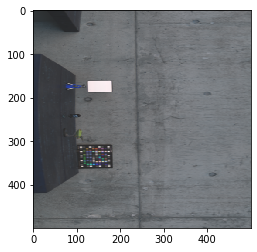

In [10]:
plt.imshow(x_test_lr[1][:,:,[7,15,21]]/np.max(x_test_lr[1][:,:,[7,15,21]]))
plt.show()

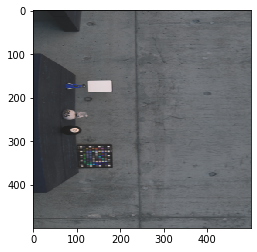

In [11]:
plt.imshow(x_train_hr[1][:,:,[7,15,21]]/np.max(x_train_hr[1][:,:,[7,15,21]]))
plt.show()

In [ ]:
!pip install rawpy

In [12]:
#Functions.py
import tensorflow as tf
from numpy.core.overrides import array_function_dispatch, set_module
from numpy.fft import ifftshift
from numpy.core import integer, empty, arange, asarray, roll
import numpy as np

__all__ = ['fftshift', 'ifftshift', 'fftfreq', 'rfftfreq']


def least_common_multiple(a, b):
    return abs(a * b) / np.math.gcd(a, b) if a and b else 0


def area_downsampling_tf(input_image, target_side_length):
    input_shape = input_image.shape.as_list()
    input_image = tf.cast(input_image, tf.float32)

    if not input_shape[1] % target_side_length:
        factor = int(input_shape[1] / target_side_length)
        output_img = tf.nn.avg_pool(input_image,
                                    [1, factor, factor, 1],
                                    strides=[1, factor, factor, 1],
                                    padding="VALID")
    else:
        # We upsample the image and then average pool
        lcm_factor = least_common_multiple(target_side_length, input_shape[1]) / target_side_length

        if lcm_factor > 10:
            print(
                "Warning: area downsampling is very expensive and not precise if source and target wave length have a large least common multiple")
            upsample_factor = 10
        else:
            upsample_factor = int(lcm_factor)
        img_upsampled = tf.image.resize(input_image, size=2 * [upsample_factor * target_side_length])
        # img_upsampled = tf.image.resize_nearest_neighbor(input_image,
        #                                                size=2 * [upsample_factor * target_side_length])
        output_img = tf.nn.avg_pool(img_upsampled,
                                    [1, upsample_factor, upsample_factor, 1],
                                    strides=[1, upsample_factor, upsample_factor, 1],
                                    padding="VALID")

    return output_img


def transp_fft2d(a_tensor, dtype=tf.complex64):
    """Takes images of shape [batch_size, x, y, channels] and transposes them
    correctly for tensorflows fft2d to work.
    """
    # Tensorflow's fft only supports complex64 dtype
    a_tensor = tf.cast(a_tensor, tf.complex64)
    # Tensorflow's FFT operates on the two innermost (last two!) dimensions
    a_tensor_transp = tf.transpose(a_tensor, [0, 3, 1, 2])
    a_fft2d = tf.signal.fft2d(a_tensor_transp)
    a_fft2d = tf.cast(a_fft2d, dtype)
    a_fft2d = tf.transpose(a_fft2d, [0, 2, 3, 1])
    return a_fft2d


def transp_ifft2d(a_tensor, dtype=tf.complex64):
    a_tensor = tf.transpose(a_tensor, [0, 3, 1, 2])
    a_tensor = tf.cast(a_tensor, tf.complex64)
    a_ifft2d_transp = tf.signal.ifft2d(a_tensor)
    # Transpose back to [batch_size, x, y, channels]
    a_ifft2d = tf.transpose(a_ifft2d_transp, [0, 2, 3, 1])
    a_ifft2d = tf.cast(a_ifft2d, dtype)
    return a_ifft2d


def compl_exp_tf(phase, dtype=tf.complex64, name='complex_exp'):
    """Complex exponent via euler's formula, since Cuda doesn't have a GPU kernel for that.
    Casts to *dtype*.
    """
    phase = tf.cast(phase, tf.float64)
    return tf.add(tf.cast(tf.cos(phase), dtype=dtype),
                  1.j * tf.cast(tf.sin(phase), dtype=dtype),
                  name=name)


def _fftshift_dispatcher(x, axes=None):
    return (x,)


@array_function_dispatch(_fftshift_dispatcher, module='numpy.fft')
def fftshift(x, axes=None):
    """
    Shift the zero-frequency component to the center of the spectrum.

    This function swaps half-spaces for all axes listed (defaults to all).
    Note that ``y[0]`` is the Nyquist component only if ``len(x)`` is even.

    Parameters
    ----------
    x : array_like
        Input array.
    axes : int or shape tuple, optional
        Axes over which to shift.  Default is None, which shifts all axes.

    Returns
    -------
    y : ndarray
        The shifted array.

    """
    x = asarray(x)
    if axes is None:
        axes = tuple(range(x.ndim))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(axes, integer_types):
        shift = x.shape[axes] // 2
    else:
        shift = [x.shape[ax] // 2 for ax in axes]

    return roll(x, shift, axes)


@array_function_dispatch(_fftshift_dispatcher, module='numpy.fft')
def ifftshift(x, axes=None):
    """
    The inverse of `fftshift`. Although identical for even-length `x`, the
    functions differ by one sample for odd-length `x`.

    Parameters
    ----------
    x : array_like
        Input array.
    axes : int or shape tuple, optional
        Axes over which to calculate.  Defaults to None, which shifts all axes.

    Returns
    -------
    y : ndarray
        The shifted array.

    See Also
    --------
    fftshift : Shift zero-frequency component to the center of the spectrum.
    """
    x = asarray(x)
    if axes is None:
        axes = tuple(range(x.ndim))
        shift = [-(dim // 2) for dim in x.shape]
    elif isinstance(axes, integer_types):
        shift = -(x.shape[axes] // 2)
    else:
        shift = [-(x.shape[ax] // 2) for ax in axes]

    return roll(x, shift, axes)


@set_module('numpy.fft')
def fftfreq(n, d=1.0):
    """
    Return the Discrete Fourier Transform sample frequencies.

    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.

    Given a window length `n` and a sample spacing `d`::

      f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.

    Returns
    -------
    f : ndarray
        Array of length `n` containing the sample frequencies.
    """
    if not isinstance(n, integer_types):
        raise ValueError("n should be an integer")
    val = 1.0 / (n * d)
    results = empty(n, int)
    N = (n - 1) // 2 + 1
    p1 = arange(0, N, dtype=int)
    results[:N] = p1
    p2 = arange(-(n // 2), 0, dtype=int)
    results[N:] = p2
    return results * val


@set_module('numpy.fft')
def rfftfreq(n, d=1.0):
    """
    Return the Discrete Fourier Transform sample frequencies
    (for usage with rfft, irfft).

    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.

    Given a window length `n` and a sample spacing `d`::

      f = [0, 1, ...,     n/2-1,     n/2] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2-1, (n-1)/2] / (d*n)   if n is odd

    Unlike `fftfreq` (but like `scipy.fftpack.rfftfreq`)
    the Nyquist frequency component is considered to be positive.

    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.

    Returns
    -------
    f : ndarray
        Array of length ``n//2 + 1`` containing the sample frequencies.


    """
    if not isinstance(n, integer_types):
        raise ValueError("n should be an integer")
    val = 1.0 / (n * d)
    N = n // 2 + 1
    results = arange(0, N, dtype=int)
    return results * val


def fftshift2d_tf(a_tensor):
    input_shape = a_tensor.shape.as_list()

    new_tensor = a_tensor
    for axis in range(1, 3):
        split = (input_shape[axis] + 1) // 2
        mylist = np.concatenate((np.arange(split, input_shape[axis]), np.arange(split)))
        new_tensor = tf.gather(new_tensor, mylist, axis=axis)
    return new_tensor


def ifftshift2d_tf(a_tensor):
    input_shape = a_tensor.shape.as_list()

    new_tensor = a_tensor
    for axis in range(1, 3):
        n = input_shape[axis]
        split = n - (n + 1) // 2
        mylist = np.concatenate((np.arange(split, n), np.arange(split)))
        new_tensor = tf.gather(new_tensor, mylist, axis=axis)
    return new_tensor


def psf2otf(input_filter, output_size):
    '''Convert 4D tensorflow filter into its FFT.

    :param input_filter: PSF. Shape (height, width, num_color_channels, num_color_channels)
    :param output_size: Size of the output OTF.
    :return: The otf.
    '''
    # pad out to output_size with zeros
    # circularly shift so center pixel is at 0,0
    fh, fw, _, _ = input_filter.shape.as_list()

    if output_size[0] != fh:
        pad = (output_size[0] - fh) / 2

        if (output_size[0] - fh) % 2 != 0:
            pad_top = pad_left = int(np.ceil(pad))
            pad_bottom = pad_right = int(np.floor(pad))
        else:
            pad_top = pad_left = int(pad) + 1
            pad_bottom = pad_right = int(pad) - 1

        padded = tf.pad(input_filter, [[pad_top, pad_bottom],
                                       [pad_left, pad_right], [0, 0], [0, 0]], "CONSTANT")
    else:
        padded = input_filter

    padded = tf.transpose(padded, [2, 0, 1, 3])
    padded = ifftshift2d_tf(padded)
    padded = tf.transpose(padded, [1, 2, 0, 3])

    ## Take FFT
    tmp = tf.transpose(padded, [2, 3, 0, 1])
    tmp = tf.signal.fft2d(tf.complex(tmp, 0.))
    return tf.transpose(tmp, [2, 3, 0, 1])


def img_psf_conv(img, psf, otf=None, adjoint=False, circular=False):
    '''Performs a convolution of an image and a psf in frequency space.

    :param img: Image tensor.
    :param psf: PSF tensor.
    :param otf: If OTF is already computed, the otf.
    :param adjoint: Whether to perform an adjoint convolution or not.
    :param circular: Whether to perform a circular convolution or not.
    :return: Image convolved with PSF.
    '''
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    psf = tf.convert_to_tensor(psf, dtype=tf.float32)

    img_shape = img.shape.as_list()

    if not circular:
        target_side_length = 2 * img_shape[1]

        height_pad = (target_side_length - img_shape[1]) / 2
        width_pad = (target_side_length - img_shape[1]) / 2

        pad_top, pad_bottom = int(np.ceil(height_pad)), int(np.floor(height_pad))
        pad_left, pad_right = int(np.ceil(width_pad)), int(np.floor(width_pad))

        img = tf.pad(img, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], "CONSTANT")
        img_shape = img.shape.as_list()

    img_fft = transp_fft2d(img)

    if otf is None:
        otf = psf2otf(psf, output_size=img_shape[1:3])
        otf = tf.transpose(otf, [2, 0, 1, 3])

    otf = tf.cast(otf, tf.complex64)
    img_fft = tf.cast(img_fft, tf.complex64)

    if adjoint:
        result = transp_ifft2d(img_fft * tf.math.conj(otf))
    else:
        result = transp_ifft2d(img_fft * otf)

    result = tf.cast(tf.math.real(result), tf.float32)

    if not circular:
        result = result[:, pad_top:-pad_bottom, pad_left:-pad_right, :]

    return result


def deta(Lb):
    Lb = Lb / 1e-6
    IdLens = 1.5375 + 0.00829045 * (Lb ** -2) - 0.000211046 * (Lb ** -4)
    IdAir = 1 + 0.05792105 / (238.0185 - Lb ** -2) + 0.00167917 / (57.362 - Lb ** -2)
    val = abs(IdLens - IdAir)
    return val

In [13]:
from tensorflow.keras.layers import Layer  # quitar tensorflow si usa keras solo
import numpy as np
import os
import rawpy
import cv2
from scipy.io import loadmat
from tensorflow.keras.constraints import NonNeg

class Psf_layer(Layer):

    def __init__(self, sensor_size, bands, **kwargs):
        self.sensor_size = sensor_size
        self.bands = bands
        super(Psf_layer, self).__init__(**kwargs)

    def get_config(self):

      config = super().get_config().copy()
      config.update({
          'sensor_size': self.sensor_size,
          'bands': self.bands,
      })
      return config

    def build(self, input_shape):
        ban= np.linspace(1,70,31, dtype=int, endpoint=False)
        self.psfs = np.zeros((self.sensor_size, self.sensor_size, self.bands))        
        psfs_load = loadmat('./psf/spiral_psfs512.mat').get('psf_small')
        for j,i in enumerate(ban):
            rgb = psfs_load[:,:,i]
            rgb = cv2.resize(rgb,(self.sensor_size,self.sensor_size))
            self.psfs[:,:,j] = rgb[:,:]        
        
        '''
        start_index = 208
        name_prefix = './psf/PSF_samuel/IMG_0' #leer las psfs
        self.psfs = np.zeros((self.sensor_size, self.sensor_size, self.bands))
        for i in range(self.bands):
            name_f = name_prefix + str(start_index) + '.CR2'
            raw = rawpy.imread(name_f)
            rgb = raw.postprocess()
            rgb = cv2.resize(rgb,(self.sensor_size,self.sensor_size))
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
            self.psfs[:,:,i] = rgb[:,:]
            #temp = np.zeros((self.sensor_size, self.sensor_size))
            #temp[123:127,123]=0.1
            #temp[123,123:127]=0.1
            #self.psfs[:,:,i] = temp
            start_index = start_index + 1'''
            
        temp = loadmat('./Sensor_31.mat') #depende del numero de bandas
        self.bgr_response = np.concatenate((temp['B'], temp['G'], temp['R']))
        self.bgr_response = tf.cast(self.bgr_response, dtype=tf.float32)
        self.bgr_response = tf.expand_dims(tf.expand_dims(tf.expand_dims(self.bgr_response, -1), -1), -1)
        self.psfs = tf.convert_to_tensor(self.psfs, dtype=tf.float32)
        self.psfs = tf.expand_dims(self.psfs,axis=0)
        self.psfs = tf.transpose(self.psfs, [1, 2, 0, 3])
        super(Psf_layer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        
        
        output_image = img_psf_conv(inputs, self.psfs)
        output_image = tf.cast(output_image, tf.float32)
        # size bands,with, height, batch
        output_image = tf.transpose(output_image, [3, 1, 2, 0])
        # size 3,bands

        # size 3,bands,1,1

        # size 3,width, height,batch
        # prueba------------------------
        #---------------------------------------------
        output_image = tf.multiply(self.bgr_response, output_image)
        output_image = tf.reduce_sum(output_image, axis=1,keepdims=False)
        # size batch,width, height,3
        output_image = tf.transpose(output_image, [3, 1, 2, 0]) 
        return output_image

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [14]:
inputs = Input(shape=(500,500,31))
conv_psf = Psf_layer(sensor_size=500, bands=31)(inputs)
#la salida de aca tiene 3 bandas, y aca se pone la red
model_merge = Model(inputs, conv_psf)

optimizad = tf.keras.optimizers.Adam()
model_merge.compile(optimizer=optimizad, loss='mean_squared_error')


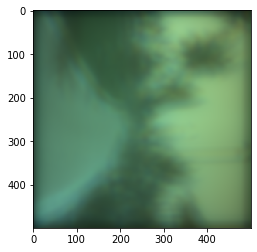

In [15]:
salida=model_merge.predict(x_test_lr)
plt.imshow(salida[2,:,:,:]/np.max(salida))
plt.show()

In [16]:
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [17]:
def up_sampling_block(model, kernal_size, filters, strides):

    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [18]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [19]:
class Generator(object):

    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape

		
    def generator(self):
        
	    gen_input = Input(shape = self.noise_shape)

	    conv_psf = Psf_layer(sensor_size=500, bands=31)(gen_input)

	    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(conv_psf)
	    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
	    
	    gen_model = model
        
        # Using 16 Residual Blocks
	    for index in range(16):
	        model = res_block_gen(model, 3, 64, 1)
	    
	    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
	    model = BatchNormalization(momentum = 0.5)(model)
	    model = add([gen_model, model])
	    
	    # Using 2 UpSampling Blocks
	    #for index in range(1):
	     #   model = up_sampling_block(model, 3, 256, 1)
	    
	    model = Conv2D(filters = 31, kernel_size = 9, strides = 1, padding = "same")(model)
	    model = Activation('tanh')(model)
	   
	    generator_model = Model(inputs = gen_input, outputs = model)
        
	    return generator_model
    

In [20]:
image_shape = x_train_hr[1].shape
shape = (image_shape[0], image_shape[1], L_imput)
generator = Generator(shape).generator()


In [21]:
x=generator.predict(x_test_lr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


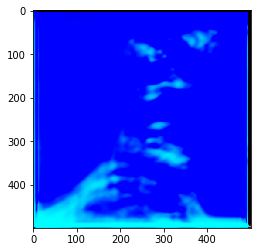

In [22]:
plt.imshow(x[2][:,:,[7,15,21]]/np.max(x[2][:,:,[7,15,21]]))
plt.show()

In [23]:
image_shape = x_train_lr[1].shape
downscale_factor=2
shape = (image_shape[0], image_shape[1], L_imput)
generator = Generator(shape).generator()
plot_model(generator,show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [24]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500, 500, 31 0                                            
__________________________________________________________________________________________________
psf_layer_2 (Psf_layer)         (None, 500, 500, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 500, 500, 64) 15616       psf_layer_2[0][0]                
__________________________________________________________________________________________________
p_re_lu_17 (PReLU)              (None, 500, 500, 64) 64          conv2d_35[0][0]                  
____________________________________________________________________________________________

In [25]:
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model


In [26]:
discriminator = Discriminator(x_train_hr.shape[1:]).discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer='adam')
plot_model(discriminator,show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [27]:
discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500, 500, 31)]    0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 500, 500, 64)      17920     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500, 500, 64)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 250, 250, 64)      36928     
_________________________________________________________________
batch_normalization_66 (Batc (None, 250, 250, 64)      256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 250, 250, 128)     7385

In [28]:
def vgg_loss(y_true, y_pred):
    return 20*tf.reduce_mean(tf.norm(y_true - y_pred, ord=2, axis=-1)) + tf.reduce_mean(tf.norm(y_true - y_pred, ord='fro', axis=[1,2]))


In [29]:
def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [30]:
import shutil
if os.path.isdir(os.getcwd() +'/output'):
  print('directorio ya existe... removiendo y creando uno nuevo...')
  shutil.rmtree(os.getcwd() + '/output')
  os.makedirs(os.getcwd() + '/output')
else:
  os.makedirs(os.getcwd() + '/output')

directorio ya existe... removiendo y creando uno nuevo...


In [31]:
#Entrenamiento

from tqdm import tqdm
import numpy as np
import argparse
image_shape = x_train_hr[1].shape
downscale_factor = 2
def train(epochs=1, batch_size=128):

    
    
    batch_count = int(x_train_hr.shape[0] / batch_size)
    shape = (image_shape[0], image_shape[1], L_imput)
    
    generator = Generator(shape).generator()
    discriminator = Discriminator(image_shape).discriminator()

    adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    generator.compile(loss=vgg_loss, optimizer=adam)
    discriminator.compile(loss="binary_crossentropy", optimizer=adam)
    
    gan = get_gan_network(discriminator, shape, generator, adam)

    for e in range(1, epochs+1):
        print ('*'*15, 'Epoch %d' % e, '*'*15, '\n')
        for _ in tqdm(range(batch_count)):
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]
            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])
            
        print('Discriminator loss : {} \n'.format(d_loss))
        print("Loss HR , Loss LR, Loss GAN")
        print(d_loss_real, d_loss_fake, loss_gan)

        #if e == 1 or e % 10 == 0:
         #   plot_generated_images(e, generator)
        if e % 5 == 0 or e % 50 == 0:
            generator.save('./output/gen_model%d.h5' % e)
            #discriminator.save('./output/dis_model%d.h5' % e)
            #gan.save('./output/gan_model%d.h5' % e)




In [32]:
train(5,2)

  0%|          | 0/15 [00:00<?, ?it/s]

*************** Epoch 1 *************** 



  0%|          | 0/15 [00:00<?, ?it/s]

Discriminator loss : 6.663847923278809 

Loss HR , Loss LR, Loss GAN
11.534045 1.7936503 [161.8533, 161.81119, 42.1111]
*************** Epoch 2 *************** 



  0%|          | 0/15 [00:00<?, ?it/s]

Discriminator loss : 6.003870964050293 

Loss HR , Loss LR, Loss GAN
7.656661 4.351081 [95.71981, 95.66452, 55.288277]
*************** Epoch 3 *************** 



  0%|          | 0/15 [00:00<?, ?it/s]

Discriminator loss : 5.568659782409668 

Loss HR , Loss LR, Loss GAN
8.774118 2.3632014 [73.97412, 73.86178, 112.34313]
*************** Epoch 4 *************** 



  0%|          | 0/15 [00:00<?, ?it/s]

Discriminator loss : 19.04097557067871 

Loss HR , Loss LR, Loss GAN
16.76038 21.321571 [68.04289, 67.96209, 80.80561]
*************** Epoch 5 *************** 



100%|██████████| 15/15 [00:21<00:00,  1.44s/it]


Discriminator loss : 8.706197738647461 

Loss HR , Loss LR, Loss GAN
2.1203442 15.29205 [42.754272, 42.74868, 5.5930233]


In [33]:
def plot_test_generated_images_for_model(output_dir, generator, x_test_lr, x_test_hr , dim=(1, 3), figsize=(15, 5)):
    
    '''
    examples = x_test_hr.shape[0]
    image_batch_hr = denormalize(x_test_hr)
    image_batch_lr = x_test_lr
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    '''
    examples = x_test_hr.shape[0]
    image_batch_hr = x_test_hr
    image_batch_lr = x_test_lr
    generated_image = generator.predict(image_batch_lr)
    

    
    for index in range(examples):
    
        plt.figure(figsize=figsize)
    
        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(image_batch_lr[index][:,:,[7,15,21]])#, interpolation='nearest')
        plt.axis('off')
        
        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(generated_image[index][:,:,[7,15,21]])#, interpolation='nearest')
        plt.axis('off')
    
        plt.subplot(dim[0], dim[1], 3)
        plt.imshow(image_batch_hr[index][:,:,[7,15,21]])#, interpolation='nearest')
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig(output_dir + 'test_generated_image_%d.png' % index)

In [34]:
def plot_test_generated_images(output_dir, generator, x_test_lr, figsize=(5, 5)):
    
    examples = x_test_lr.shape[0]
    image_batch_lr = denormalize(x_test_lr)
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    
    for index in range(examples):
    
        #plt.figure(figsize=figsize)
    
        plt.imshow(generated_image[index][:,:,[7,15,21]], interpolation='nearest')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(output_dir + 'high_res_result_image_%d.png' % index)
    
        #plt.show()

In [38]:
#Test
def test_model(model,output_dir, x_test_lr, x_test_hr):

  plot_test_generated_images_for_model(output_dir, model, x_test_lr, x_test_hr)



In [35]:
def denormalize(input_data):
    input_data = (input_data ) * np.max(input_data)
    return input_data.astype(np.uint8)

In [36]:
from tensorflow.keras.models import load_model
model = load_model('./output/gen_model5.h5', custom_objects={'vgg_loss': vgg_loss, 'Psf_layer': Psf_layer })

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


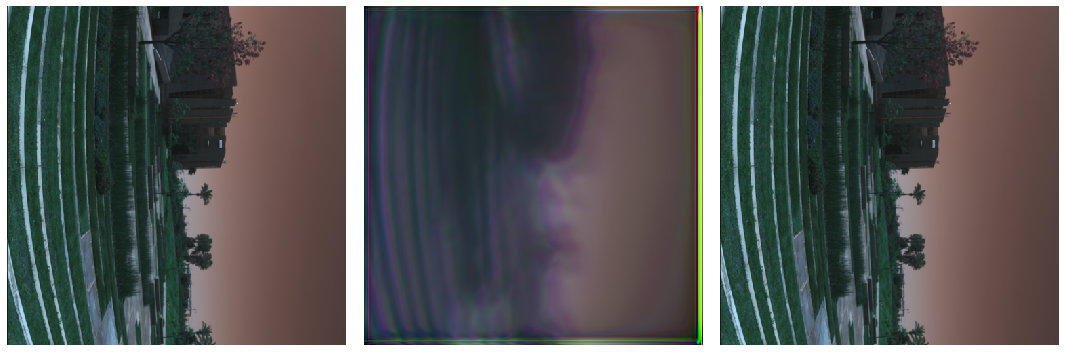

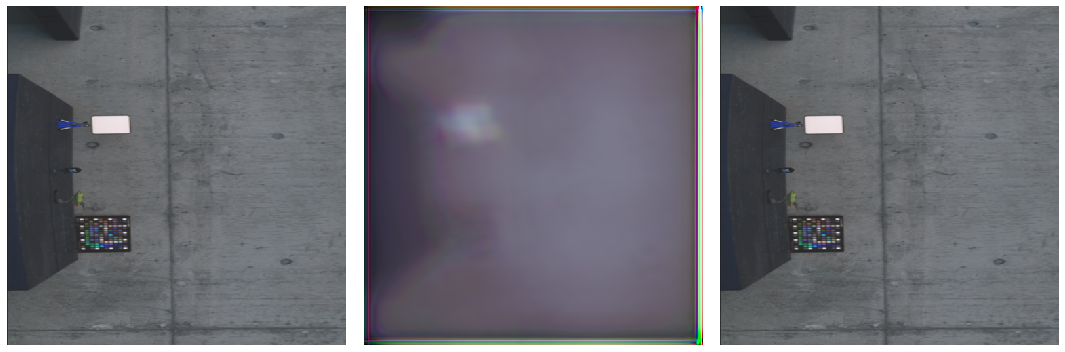

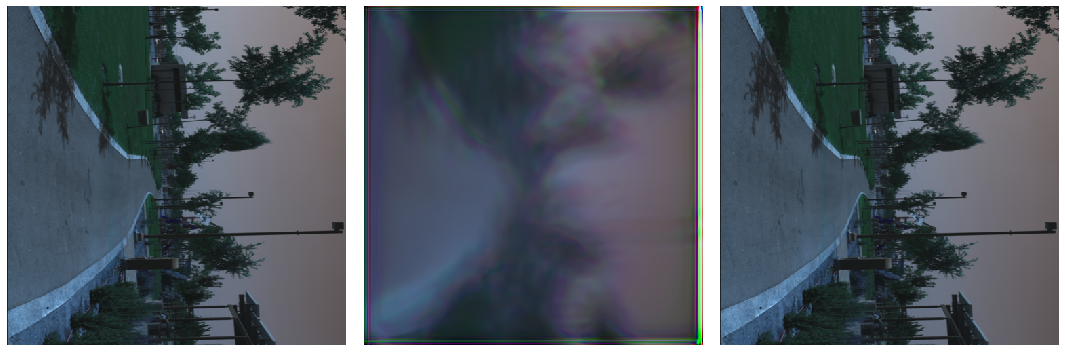

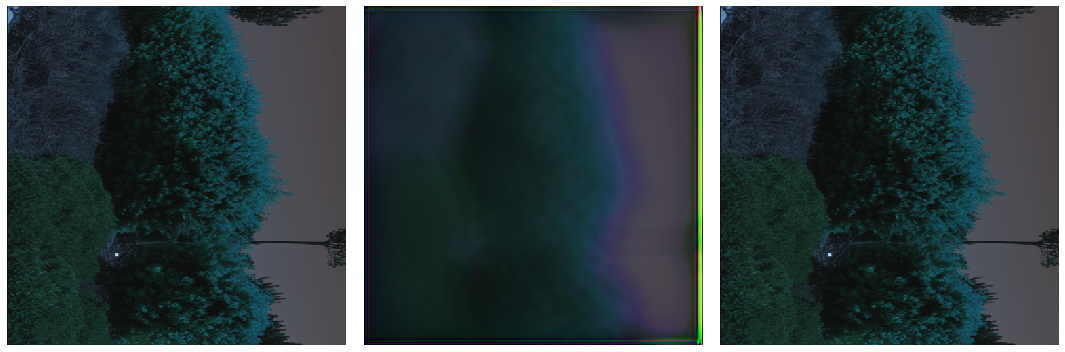

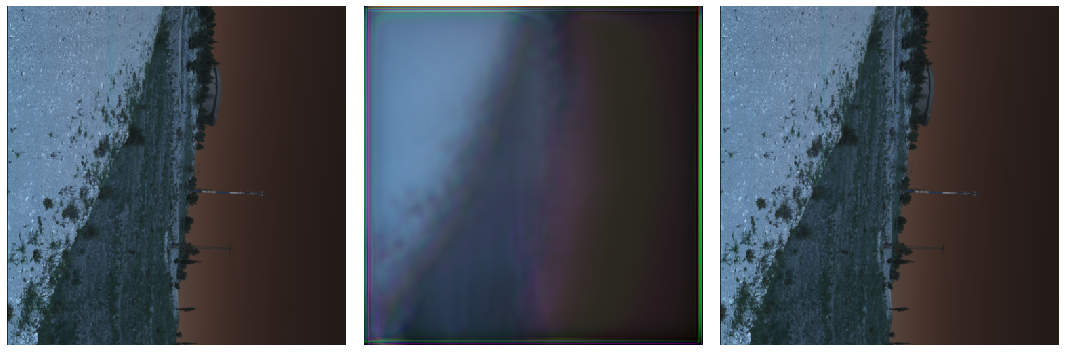

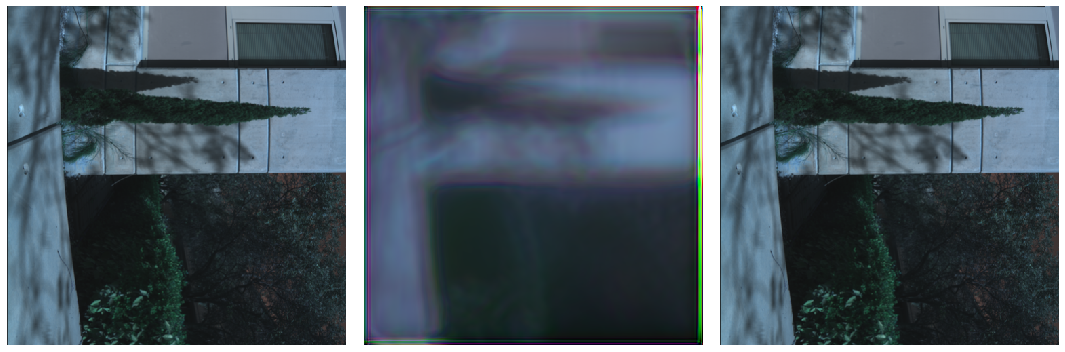

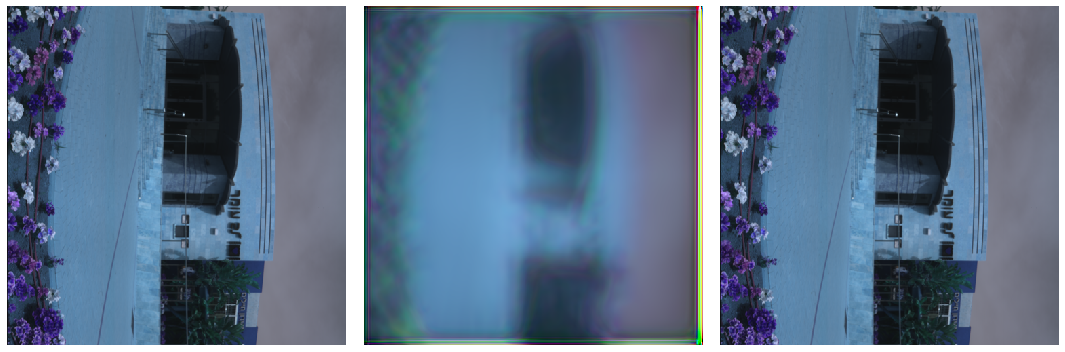

In [39]:
# testando el modelo
path_out = './output'
test_model(model, path_out, x_test_lr, x_test_hr )